<a href="https://colab.research.google.com/github/Mokafe/Mokafe-ulysses-narrative-gmm/blob/main/00_ulysses_gmm_report_v1_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ulysses Narrative GMM Turning Points（01: Colab実行＋状態凡例＋転調点探索）

このノートは、`data/sample/ulysses_stream.csv`（または `ulysses_fixed.json`）を入力として、  
章ごとの時系列特徴（`mode_ / cause_ / style_ / place_ / myth_`）を **Gaussian Mixture Model（GMM）で潜在状態（state）に要約**し、  
その上で **潜在状態の“境界候補”（turning points）**を抽出・可視化する「作業用・再現性優先」ノートです。

---

## 重要：このノートの **entropy** は **GMM 側の boundaryness** です

本ノートで扱う `entropy` は、GMM の `predict_proba()` が返す **潜在状態の事後確率（responsibility）** のエントロピーです。  
値が高いほど **「どの state に属するかが拮抗している（境界っぽい）」**ことを表します。

> **注意**：別ノートで出てくる **LLM側 entropy（`transition_type` 分類の迷い）**とは別物です。  
> 本ノートでは「転調タイプ分類」ではなく、**潜在状態（記述モード等の混合）の境界候補**を扱います。

---

## このノートで得られるもの（成果物）

- `k_selection_table.csv`：K候補（BIC/AIC/Silhouette）一覧
- `state_counts_table.csv`：state 出現数
- `state_profile_z_table.csv`：stateごとの特徴量平均（zスコア）
- `state_top_features_table.csv`：stateの上位特徴（z上位）
- `state_legend_table.csv`：**state凡例**（top_features / 多い章 / 代表span）
- `fig_cluster_pca_ellipse.png`：PCA散布図＋共分散楕円（境界候補を強調）
- `fig_transition_matrix.png`：状態遷移確率行列
- `fig_chapter_cluster_share.png`：章別state占有率
- `fig_entropy_timeseries.png`：boundaryness（entropy）時系列
- `boundary_report.csv`：境界候補の全件表
- `turning_points_top10.csv` / `turning_points_top10.tsv`：境界候補 上位の要約

> **読み方**：上から順に  
> **環境構築 → データ読み込み → 特徴量整形 → K選択 → state推定 → state凡例（誤解防止） → 可視化 → 境界候補抽出**  
> という流れです。

---

## turning points の位置づけ（過剰解釈防止）

本ノートの turning points は、文学的な“劇的転機”の断定ではなく、  
**特徴量空間で state が競り合う地点（局所的に解釈負荷が上がりやすい候補）**を機械的に列挙するものです。  

- 人物解釈やストーリー解釈は行いません  
- 必要に応じて `evidence_ja` を添え、**どのような記述特徴が効いたか**を確認します

---

## 0. セットアップ（迷子防止）

**目的**：Colab上で毎回同じ状態から開始し、実行環境の差によるエラーを潰す。  
**入力/前提**：GitHub repo URL。  
**出力**：`/content/Mokafe-ulysses-narrative-gmm` に clone＋依存導入。  
**注意**：ColabはCWDがズレると後続が崩れるので、最後に **CWD** と **`data/sample/` の存在**を必ず確認する。


In [1]:
import os, sys, shutil
from pathlib import Path

REPO_URL = "https://github.com/Mokafe/Mokafe-ulysses-narrative-gmm.git"
REPO_DIR = Path("/content/Mokafe-ulysses-narrative-gmm")

if REPO_DIR.exists():
    shutil.rmtree(REPO_DIR)

%cd /content
!git clone {REPO_URL}
%cd {REPO_DIR}

!pip install -r requirements.txt

src_dir = Path.cwd() / "src"
assert src_dir.exists(), f"src not found: {src_dir}"
sys.path.insert(0, str(src_dir))

print("✅ Setup done")
print("CWD:", os.getcwd())


/content
Cloning into 'Mokafe-ulysses-narrative-gmm'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 107 (delta 49), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (107/107), 901.46 KiB | 6.99 MiB/s, done.
Resolving deltas: 100% (49/49), done.
/content/Mokafe-ulysses-narrative-gmm
✅ Setup done
CWD: /content/Mokafe-ulysses-narrative-gmm


In [2]:
import os
from pathlib import Path

print("CWD:", os.getcwd())

REPO_DIR = Path("/content/Mokafe-ulysses-narrative-gmm")
assert REPO_DIR.exists(), f"repo not found: {REPO_DIR}"

# JSONをrepo内から自動検索（大小文字どちらでも）
cands = list(REPO_DIR.rglob("ulysses_fixed.json")) + list(REPO_DIR.rglob("Ulysses_fixed.json"))
print("JSON candidates:", [str(p) for p in cands])

if not cands:
    raise FileNotFoundError("ulysses_fixed.json がrepo内に見つかりません")

DATA_JSON = str(cands[0])  # 見つかった最初の1つを採用
DATA_CSV  = str(REPO_DIR / "data" / "sample" / "ulysses_stream.csv")  # 生成先も固定（ここは好みで変更可）

print("Using DATA_JSON:", DATA_JSON)
print("Using DATA_CSV :", DATA_CSV)
print("exists?", os.path.exists(DATA_JSON), os.path.exists(DATA_CSV))


CWD: /content/Mokafe-ulysses-narrative-gmm
JSON candidates: ['/content/Mokafe-ulysses-narrative-gmm/data/sample/ulysses_fixed.json']
Using DATA_JSON: /content/Mokafe-ulysses-narrative-gmm/data/sample/ulysses_fixed.json
Using DATA_CSV : /content/Mokafe-ulysses-narrative-gmm/data/sample/ulysses_stream.csv
exists? True True


In [3]:
!pip -q install japanize-matplotlib pingouin umap-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 12.6 MB/s eta 0:00:00


In [4]:
import os, json, math, textwrap
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score

sns.set_context("talk")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATA_CSV  = "/content/Mokafe-ulysses-narrative-gmm/data/sample/ulysses_stream.csv"
DATA_JSON = "/content/Mokafe-ulysses-narrative-gmm/data/sample/ulysses_fixed.json"


def json_to_csv(json_path=DATA_JSON, csv_path=DATA_CSV):
    if not os.path.exists(json_path):
        raise FileNotFoundError(f"{json_path} not found. Please check repo path: {DATA_JSON}")


    data = json.loads(open(json_path, "r", encoding="utf-8").read())
    rows = []
    for ch in data:
        meta = ch.get("chapter_meta", {}) or {}
        episode_default = meta.get("episode", ch.get("episode", None))
        doc_id = ch.get("doc_id")

        for p in ch.get("time_series_data", []):
            episode = p.get("episode", episode_default)
            r = {
                "doc_id": doc_id,
                "chapter": int(episode) if episode is not None else None,
                "span_id": int(p.get("global_step")) if p.get("global_step") is not None else None,
                "transition_type": p.get("transition_type"),
                "anchor_time": (p.get("anchor") or {}).get("time_anchor"),
                "anchor_place": (p.get("anchor") or {}).get("place_anchor"),
                "anchor_strength": (p.get("anchor") or {}).get("anchor_strength"),
                "evidence_en": p.get("evidence_en"),
                "evidence_ja": p.get("evidence_ja"),
            }
            for k, v in (p.get("mode") or {}).items():
                r[f"mode_{k}"] = float(v) if v is not None else np.nan
            for k, v in (p.get("cause_weights") or {}).items():
                r[f"cause_{k}"] = float(v) if v is not None else np.nan
            for i, v in enumerate(p.get("place_vec") or []):
                r[f"place_{i}"] = float(v)
            for i, v in enumerate(p.get("myth_vec") or []):
                r[f"myth_{i}"] = float(v)
            for k, v in (p.get("style") or {}).items():
                r[f"style_{k}"] = float(v) if v is not None else np.nan
            rows.append(r)

    df = pd.DataFrame(rows).sort_values(["chapter","span_id"]).reset_index(drop=True)
    df.to_csv(csv_path, index=False, encoding="utf-8-sig")
    print("saved:", csv_path, "shape=", df.shape)
    return df

# CSVがなければJSONから生成
if not os.path.exists(DATA_CSV):
    print("CSVが無いのでJSONから生成します:", DATA_JSON)
    df = json_to_csv(DATA_JSON, DATA_CSV)
else:
    df = pd.read_csv(DATA_CSV)
    print("loaded:", DATA_CSV, "shape=", df.shape)

# 必須列の最低チェック
assert "chapter" in df.columns, "chapter列がありません"
assert "span_id" in df.columns, "span_id列がありません"

df = df.sort_values(["chapter","span_id"]).reset_index(drop=True)
display(df.head(3))


loaded: /content/Mokafe-ulysses-narrative-gmm/data/sample/ulysses_stream.csv shape= (555, 38)


,doc_id,chapter,span_id,transition_type,anchor_time,anchor_place,anchor_strength,mode_perception,mode_inner_speech,mode_memory,...,myth_1,myth_2,myth_3,style_syntax_break,style_ellipsis,style_intertext_density,style_language_shift,style_phonetic_play,evidence_en,evidence_ja
0,ulysses_ep01_v1,1,1,intrusion,now,here,0.8,0.75,0.05,0.0,...,0.05,0.05,0.05,0.10,0.0,0.00,0.0,0.00,Buck Mulligan came from the stairhead,視覚描写（人物の出現）による開始。
1,ulysses_ep01_v1,1,2,script_switch,now,here,0.7,0.05,0.05,0.0,...,0.05,0.08,0.05,0.20,0.0,0.85,0.9,0.05,Introibo ad altare Dei,非英語（ラテン語）での引用/唱和。
2,ulysses_ep01_v1,1,3,intrusion,now,here,0.8,0.05,0.00,0.0,...,0.05,0.05,0.05,0.15,0.0,0.00,0.0,0.05,"Come up, Kinch! Come up",命令形の呼びかけで会話モードへ。


In [5]:
# ===== パラメータ =====
USE_SMOOTHING = True
WINDOW_SIZE = 3

# 特徴量列
feature_cols = [c for c in df.columns if c.startswith(("mode_", "cause_", "place_", "myth_", "style_"))]
if len(feature_cols) == 0:
    raise ValueError("特徴量列が見つかりません（mode_/cause_/place_/myth_/style_ が必要）")

# 章ごと移動平均（任意）
if USE_SMOOTHING:
    df[feature_cols] = (
        df.groupby("chapter")[feature_cols]
          .rolling(WINDOW_SIZE, min_periods=1)
          .mean()
          .reset_index(level=0, drop=True)
    )

# 欠損補完→標準化
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X  = imputer.fit_transform(df[feature_cols])
Xz = scaler.fit_transform(X)

print("features:", len(feature_cols), " Xz:", Xz.shape)


features: 29  Xz: (555, 29)


,K,BIC,AIC,LogLik(mean),Silhouette
0,8,23513.762772,7451.520357,-0.012181,0.102329
1,5,23793.602732,13756.320836,-8.205694,0.078558
2,7,24344.991026,10291.068784,-3.408170,0.106893
3,3,24567.761461,18547.119910,-14.197405,0.061911
4,2,24604.109356,20591.787979,-16.877286,0.104911
5,6,24722.302799,12676.700730,-6.395226,0.091085
6,4,25693.117233,17664.155510,-12.564104,0.102217
7,9,27074.529540,9003.966952,-0.572943,0.093815
8,10,28521.170281,8442.287521,0.770912,0.121455
9,11,29472.547480,7385.344546,2.560951,0.109342


★最適K（BIC最小）= 8


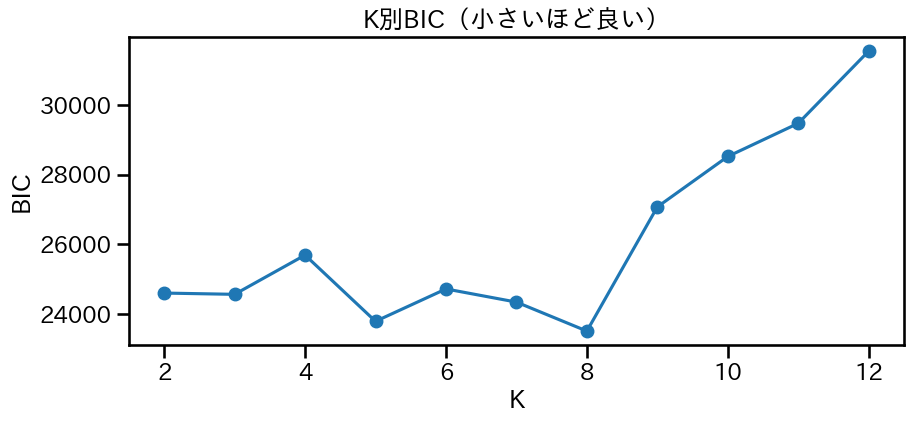

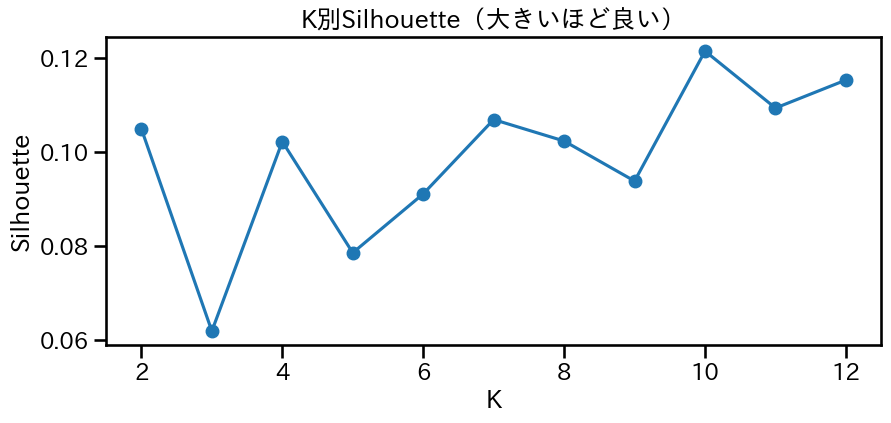

saved: k_selection_table.csv


In [6]:
K_RANGE = range(2, 13)

rows = []
models = {}
for k in K_RANGE:
    gmm = GaussianMixture(
        n_components=k, covariance_type="full",
        random_state=RANDOM_STATE, n_init=10
    )
    gmm.fit(Xz)
    ll = gmm.score(Xz)  # 平均対数尤度（大きいほど良い）
    bic = gmm.bic(Xz)
    aic = gmm.aic(Xz)
    # Silhouetteはクラスタが1つになると計算不能だがK>=2なのでOK
    labels = gmm.predict(Xz)
    sil = silhouette_score(Xz, labels)

    rows.append({"K": k, "BIC": bic, "AIC": aic, "LogLik(mean)": ll, "Silhouette": sil})
    models[k] = gmm

k_table = pd.DataFrame(rows).sort_values("BIC").reset_index(drop=True)
display(k_table)

best_k = int(k_table.iloc[0]["K"])
best_gmm = models[best_k]
print("★最適K（BIC最小）=", best_k)

# 可視化
plt.figure(figsize=(10,4))
plt.plot(k_table.sort_values("K")["K"], k_table.sort_values("K")["BIC"], marker="o")
plt.title("K別BIC（小さいほど良い）")
plt.xlabel("K"); plt.ylabel("BIC"); plt.show()

plt.figure(figsize=(10,4))
plt.plot(k_table.sort_values("K")["K"], k_table.sort_values("K")["Silhouette"], marker="o")
plt.title("K別Silhouette（大きいほど良い）")
plt.xlabel("K"); plt.ylabel("Silhouette"); plt.show()

k_table.to_csv("k_selection_table.csv", index=False, encoding="utf-8-sig")
print("saved: k_selection_table.csv")


In [7]:
def posterior_entropy(resp, eps=1e-12):
    r = np.clip(resp, eps, 1.0)
    return -(r * np.log(r)).sum(axis=1)

# 予測
df["state"] = best_gmm.predict(Xz)
df["log_likelihood"] = best_gmm.score_samples(Xz)
resp = best_gmm.predict_proba(Xz)
df["entropy"] = posterior_entropy(resp)

alpha = 0.05  # 5%
thr_ll  = np.quantile(df["log_likelihood"], alpha)
thr_ent = np.quantile(df["entropy"], 1-alpha)

anoms_ll  = df[df["log_likelihood"] <= thr_ll].copy()
anoms_ent = df[df["entropy"] >= thr_ent].copy()

print("尤度下位(特異点A) 件数:", len(anoms_ll), " / entropy上位(特異点B) 件数:", len(anoms_ent))

keyA = set(zip(anoms_ll["chapter"], anoms_ll["span_id"]))
keyB = set(zip(anoms_ent["chapter"], anoms_ent["span_id"]))
both = keyA & keyB
print("共通（A∩B）件数:", len(both))

# 保存
# 出力先
OUT_DIR = Path("outputs")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# 1) K選択テーブル
k_table_path = OUT_DIR / "k_selection_table.csv"
k_table.to_csv(k_table_path, index=False)

print("saved:", k_table_path)

# 2) anomaly candidates（尤度 / エントロピー）
anoms_ll_top50  = df.sort_values("log_likelihood", ascending=True).head(50).copy()  # ←低い順
anoms_ent_top50 = df.sort_values("entropy", ascending=False).head(50).copy()

anoms_ll_path = OUT_DIR / "anomalies_by_loglik_low50.csv"
anoms_ent_path = OUT_DIR / "anomalies_by_entropy_top50.csv"
anoms_ll_top50.to_csv(anoms_ll_path, index=False)
anoms_ent_top50.to_csv(anoms_ent_path, index=False)
print("saved:", anoms_ll_path)
print("saved:", anoms_ent_path)


# 3) boundary_report（論文/レポート用の統合テーブル）
#   - top1/top2 は事後確率 resp から算出
#   - margin が小さいほど top1/top2 が拮抗（=曖昧）
#   - evidence_best は日本語根拠（存在すれば evidence_ja を採用）
resp_np = np.asarray(resp)
top2_idx = np.argsort(-resp_np, axis=1)[:, :2]  # [N,2] (desc)
top1_k = top2_idx[:, 0]
top2_k = top2_idx[:, 1]
top1_p = resp_np[np.arange(len(resp_np)), top1_k]
top2_p = resp_np[np.arange(len(resp_np)), top2_k]
margin = top1_p - top2_p

boundary_report = df.copy()
# 状態は 1..K に変換
boundary_report["gmm_state_1based"] = boundary_report["state"].astype(int) + 1
boundary_report["top1_state_1based"] = (top1_k + 1).astype(int)
boundary_report["top1_p"] = top1_p
boundary_report["top2_state_1based"] = (top2_k + 1).astype(int)
boundary_report["top2_p"] = top2_p
boundary_report["margin"] = margin

# evidence_best: evidence_ja があればそれを、なければ evidence_en or 空
if "evidence_ja" in boundary_report.columns:
    boundary_report["evidence_best"] = boundary_report["evidence_ja"].fillna("")
elif "evidence_en" in boundary_report.columns:
    boundary_report["evidence_best"] = boundary_report["evidence_en"].fillna("")
else:
    boundary_report["evidence_best"] = ""

# rank: 元の行番号を保持（レポート参照用）
boundary_report = boundary_report.reset_index().rename(columns={"index": "rank"})

# レポートに出す主要カラム（存在すれば transition_type を含める）
preferred_cols = [
    "rank","chapter","span_id","transition_type",
    "entropy","gmm_state_1based",
    "top1_state_1based","top1_p","top2_state_1based","top2_p","margin",
    "evidence_best",
]
cols = [c for c in preferred_cols if c in boundary_report.columns]
# それ以外も残したい場合は boundary_report_full を別に保存してよい
boundary_report_out = boundary_report[cols].copy()

boundary_report_path = OUT_DIR / "boundary_report.csv"
boundary_report_out.to_csv(boundary_report_path, index=False)
print("saved:", boundary_report_path)

# 4) turning points top10（エントロピー降順）
tp10 = boundary_report_out.sort_values("entropy", ascending=False).head(10).copy()
tp10_csv = OUT_DIR / "turning_points_top10.csv"
tp10_tsv = OUT_DIR / "turning_points_top10.tsv"
tp10.to_csv(tp10_csv, index=False)
tp10.to_csv(tp10_tsv, index=False, sep="\t")
print("saved:", tp10_csv, "/", tp10_tsv)

# sanity check
if "gmm_state_1based" in boundary_report_out.columns:
    print("sanity check (should be 1..K):", int(boundary_report_out["gmm_state_1based"].min()), int(boundary_report_out["gmm_state_1based"].max()))



尤度下位(特異点A) 件数: 28  / entropy上位(特異点B) 件数: 28
共通（A∩B）件数: 1
saved: outputs/k_selection_table.csv
saved: outputs/anomalies_by_loglik_low50.csv
saved: outputs/anomalies_by_entropy_top50.csv
saved: outputs/boundary_report.csv
saved: outputs/turning_points_top10.csv / outputs/turning_points_top10.tsv
sanity check (should be 1..K): 1 8


## Exported artifacts (for report)

This notebook writes key CSV/TSV artifacts under `outputs/`:

- `k_selection_table.csv`
- `anomalies_by_llz_top50.csv`
- `anomalies_by_entropy_top50.csv`
- `boundary_report.csv`
- `turning_points_top10.csv` / `turning_points_top10.tsv`


In [8]:
# =========================================================
# STATE表（凡例）を作る（頻度・プロファイル・代表evidence）
# =========================================================

import numpy as np
import pandas as pd

# --- 0) 表示用に state を 1始まりにも用意（必要なら）
df["state_1based"] = df["state"].astype(int) + 1

K = resp.shape[1]  # 状態数

# --- 1) State頻度表
state_counts = (
    df["state"].value_counts()
      .sort_index()
      .rename_axis("state")
      .reset_index(name="count")
)
state_counts["state_1based"] = state_counts["state"] + 1
display(state_counts)
state_counts.to_csv("state_counts_table.csv", index=False, encoding="utf-8-sig")
print("saved: state_counts_table.csv")

# --- 2) Stateプロファイル（Z空間：Xz の state 別平均）
zcols = [f"{c}__z" for c in feature_cols]
df_z = pd.DataFrame(Xz, columns=zcols)
df_z["state"] = df["state"].astype(int).values

state_profile_z = df_z.groupby("state")[zcols].mean().sort_index()
state_profile_z.to_csv("state_profile_z_table.csv", encoding="utf-8-sig")
print("saved: state_profile_z_table.csv")

# --- 2.1) 各Stateの「上位特徴」TopN（凡例の核）
TOPN = 8
rows = []
for k in range(K):
    s = state_profile_z.loc[k]
    top = s.reindex(s.abs().sort_values(ascending=False).head(TOPN).index)
    rows.append({
        "state": k,
        "state_1based": k + 1,
        "top_features": "; ".join([f"{name.replace('__z','')}={val:+.2f}" for name, val in top.items()])
    })
state_topfeat = pd.DataFrame(rows)
display(state_topfeat)
state_topfeat.to_csv("state_top_features_table.csv", index=False, encoding="utf-8-sig")
print("saved: state_top_features_table.csv")

# --- 2.2) 自動ラベル案（※最終的にはあなたが編集して確定する前提）
def suggest_label_from_top(top_feature_str: str) -> str:
    s = top_feature_str
    if "mode_dialogue" in s:
        return "対話・相互作用"
    if "mode_perception" in s:
        return "外界知覚・描写"
    if ("mode_inner_speech" in s) or ("mode_reasoning" in s):
        return "内的独白・推論"
    if "mode_memory" in s:
        return "記憶想起"
    if "mode_imagination" in s:
        return "想像・仮想"
    if ("mode_quotation" in s) or ("cause_intertext" in s) or ("style_intertext_density" in s):
        return "引用・間テキスト"
    return "混合（要解釈）"

state_legend = state_topfeat.copy()
state_legend["label_suggested_ja"] = state_legend["top_features"].apply(suggest_label_from_top)
display(state_legend)
state_legend.to_csv("state_legend_table.csv", index=False, encoding="utf-8-sig")
print("saved: state_legend_table.csv")

# --- 3) State代表evidence（各Stateで「そのState確率が高い」もの上位）
# resp[i,k] を使って「代表的な点」を拾う
rep_rows = []
for k in range(K):
    pk = resp[:, k]
    idx = np.argsort(-pk)[:3]  # 上位3件（好みで増やせます）
    for rank, i in enumerate(idx, start=1):
        rep_rows.append({
            "state": k,
            "state_1based": k + 1,
            "rank_in_state": rank,
            "p_state": float(pk[i]),
            "entropy": float(df.loc[i, "entropy"]),
            "log_likelihood": float(df.loc[i, "log_likelihood"]),
            "chapter": df.loc[i, "chapter"],
            "span_id": df.loc[i, "span_id"],
            "evidence": df.loc[i, "evidence"] if "evidence" in df.columns else "",
        })
state_examples = pd.DataFrame(rep_rows)
display(state_examples.head(12))
state_examples.to_csv("state_examples_table.csv", index=False, encoding="utf-8-sig")
print("saved: state_examples_table.csv")

print("DONE: STATE凡例セット（counts/profile/topfeat/legend/examples）を出力しました。")


,state,count,state_1based
0,0,108,1
1,1,124,2
2,2,114,3
3,3,81,4
4,4,65,5
5,5,45,6
6,6,7,7
7,7,11,8


saved: state_counts_table.csv
saved: state_profile_z_table.csv


,state,state_1based,top_features
0,0,1,cause_intertext=+1.29; mode_quotation=+1.29; s...
1,1,2,place_1=+0.98; mode_dialogue=+0.86; cause_soci...
2,2,3,cause_goal_task=+0.95; mode_reasoning=+0.74; m...
3,3,4,myth_1=+1.12; cause_memory=+0.81; mode_memory=...
4,4,5,place_0=+1.53; cause_sensory=+1.07; mode_perce...
5,5,6,place_2=+2.30; mode_inner_speech=+2.17; style_...
6,6,7,style_ellipsis=+7.78; place_2=+1.01; cause_emo...
7,7,8,myth_3=+4.44; mode_dialogue=+2.34; place_1=+1....


saved: state_top_features_table.csv


,state,state_1based,top_features,label_suggested_ja
0,0,1,cause_intertext=+1.29; mode_quotation=+1.29; s...,想像・仮想
1,1,2,place_1=+0.98; mode_dialogue=+0.86; cause_soci...,対話・相互作用
2,2,3,cause_goal_task=+0.95; mode_reasoning=+0.74; m...,外界知覚・描写
3,3,4,myth_1=+1.12; cause_memory=+0.81; mode_memory=...,記憶想起
4,4,5,place_0=+1.53; cause_sensory=+1.07; mode_perce...,対話・相互作用
5,5,6,place_2=+2.30; mode_inner_speech=+2.17; style_...,内的独白・推論
6,6,7,style_ellipsis=+7.78; place_2=+1.01; cause_emo...,内的独白・推論
7,7,8,myth_3=+4.44; mode_dialogue=+2.34; place_1=+1....,対話・相互作用


saved: state_legend_table.csv


,state,state_1based,rank_in_state,p_state,entropy,log_likelihood,chapter,span_id,evidence
0,0,1,1,1.0,1.934171e-10,-14.424805,1,23,
1,0,1,2,1.0,1.934171e-10,-12.614727,1,24,
2,0,1,3,1.0,1.934171e-10,-13.459415,17,22,
3,1,2,1,1.0,1.934171e-10,-3.416519,16,29,
4,1,2,2,1.0,1.934171e-10,-1.717001,16,23,
5,1,2,3,1.0,1.934171e-10,2.716513,15,47,
6,2,3,1,1.0,1.934171e-10,-7.464165,1,1,
7,2,3,2,1.0,1.934171e-10,6.242627,17,28,
8,2,3,3,1.0,1.934171e-10,4.708762,17,27,
9,3,4,1,1.0,1.934171e-10,-10.746709,2,5,


saved: state_examples_table.csv
DONE: STATE凡例セット（counts/profile/topfeat/legend/examples）を出力しました。


メモ：本データではGMMの事後確率が鋭く、posterior entropy はほぼ0に潰れたため、境界検出の主指標には使わず、主に log-likelihood の外れ点抽出を用いる。

In [9]:
SEEDS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

ref_labels = df["state"].to_numpy()
ref_boundary = set(zip(anoms_ent["chapter"], anoms_ent["span_id"]))  # entropy上位をboundaryの代表に

def jaccard(a, b):
    if len(a | b) == 0: return 1.0
    return len(a & b) / len(a | b)

stab_rows = []
for s in SEEDS:
    g = GaussianMixture(n_components=best_k, covariance_type="full", random_state=s, n_init=10)
    g.fit(Xz)
    lab = g.predict(Xz)
    ari = adjusted_rand_score(ref_labels, lab)

    ent = posterior_entropy(g.predict_proba(Xz))
    thr = np.quantile(ent, 1-alpha)
    bd = set(zip(df.loc[ent >= thr, "chapter"], df.loc[ent >= thr, "span_id"]))
    jac = jaccard(ref_boundary, bd)

    stab_rows.append({"seed": s, "ARI_vs_ref": ari, "Jaccard_boundary_vs_ref": jac})

stab = pd.DataFrame(stab_rows)
display(stab)

print("ARI 平均:", stab["ARI_vs_ref"].mean(), " / boundary Jaccard 平均:", stab["Jaccard_boundary_vs_ref"].mean())
stab.to_csv("stability_table.csv", index=False, encoding="utf-8-sig")
print("saved: stability_table.csv")


,seed,ARI_vs_ref,Jaccard_boundary_vs_ref
0,0,0.608097,0.166667
1,1,0.321983,0.037037
2,2,0.550070,0.166667
3,3,0.337499,0.076923
4,4,0.436716,0.076923
5,5,0.453962,0.076923
6,6,0.385457,0.076923
7,7,0.535643,0.142857
8,8,0.348592,0.018182
9,9,0.450878,0.142857


ARI 平均: 0.442889678625244  / boundary Jaccard 平均: 0.0981958781958782
saved: stability_table.csv


メモ：「entropyが極小で同値が多いため、boundary集合は不安定になりやすく、Jaccardは参考」

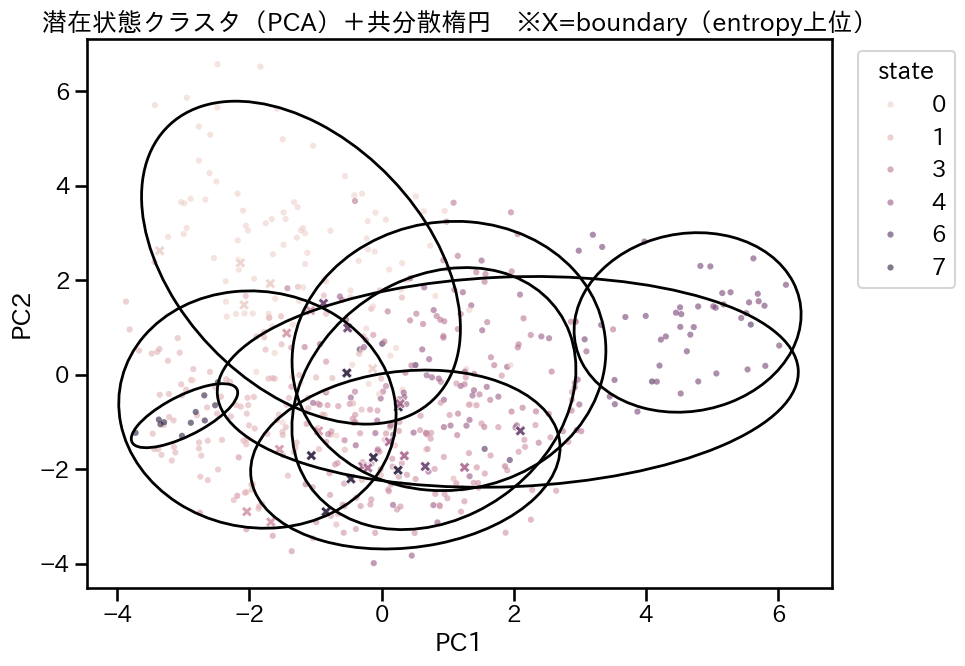

saved: fig_cluster_pca_ellipse.png


In [10]:
from matplotlib.patches import Ellipse

def cov_ellipse(mean, cov, n_std=2.0):
    # 2x2 covariance → ellipse
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)
    return width, height, theta

# PCAで2次元へ
pca = PCA(n_components=2, random_state=RANDOM_STATE)
Z = pca.fit_transform(Xz)
df["pc1"], df["pc2"] = Z[:,0], Z[:,1]

# boundary点（entropy上位）
is_boundary = df["entropy"] >= np.quantile(df["entropy"], 1-alpha)

plt.figure(figsize=(10,7))
# 点：通常
sns.scatterplot(data=df[~is_boundary], x="pc1", y="pc2", hue="state", s=20, linewidth=0, alpha=0.6)
# 点：boundary
sns.scatterplot(data=df[is_boundary], x="pc1", y="pc2", hue="state", s=60, marker="X", linewidth=0.6, alpha=0.9, legend=False)

# 楕円（クラスタごと）
for k in range(best_k):
    pts = df[df["state"]==k][["pc1","pc2"]].to_numpy()
    if len(pts) < 5:
        continue
    mu = pts.mean(axis=0)
    cov = np.cov(pts.T)
    w,h,theta = cov_ellipse(mu, cov, n_std=2.0)
    e = Ellipse(xy=mu, width=w, height=h, angle=theta, fill=False, lw=2)
    plt.gca().add_patch(e)

plt.title("潜在状態クラスタ（PCA）＋共分散楕円　※X=boundary（entropy上位）")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(title="state", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.savefig("fig_cluster_pca_ellipse.png", dpi=200)
plt.show()

print("saved: fig_cluster_pca_ellipse.png")


メモ：state は人物・場面ラベルではなく、特徴量ベクトルのクラスタID（便宜的番号）です。章で偏るのは特徴量（語り口）の偏りを反映しています。

In [11]:
# ===== State legend table (features + examples + top chapters) =====
import numpy as np
import pandas as pd

# ----------------------------
# 0) evidence列の自動検出（ja優先）
# ----------------------------
ev_col = None
for c in ["evidence_ja", "evidence_en", "span_text_ja", "span_text_en", "text", "quote"]:
    if c in df.columns:
        ev_col = c
        break
print("Detected evidence column:", ev_col)

def _short(s, n=80):
    if s is None or (isinstance(s, float) and np.isnan(s)):
        return ""
    s = str(s).replace("\n", " ").strip()
    return (s[:n] + "…") if len(s) > n else s

# ----------------------------
# 1) z特徴量をdfに（Xzを列化）
# ----------------------------
# feature_cols と Xz の整合チェック
assert len(feature_cols) == Xz.shape[1], f"feature_cols({len(feature_cols)}) != Xz.shape[1]({Xz.shape[1]})"

Zdf = pd.DataFrame(Xz, columns=feature_cols, index=df.index)  # z空間の特徴
# （既に同名列があっても上書きは避けたいので suffix をつける）
z_cols = [f"{c}__z" for c in feature_cols]
Zdf.columns = z_cols
df2 = df.copy()
df2[z_cols] = Zdf

# ----------------------------
# 2) responsibility（p_state）を計算して付与（任意だが例の選び方が安定）
# ----------------------------
resp = best_gmm.predict_proba(Xz)              # (N, K)
df2["p_state"] = resp.max(axis=1)              # 最大事後確率（確信度）
# state は既にあるはずだが念のため一致させる
df2["state"] = resp.argmax(axis=1)

# もし log_likelihood がなければ作る（例抽出で使う）
if "log_likelihood" not in df2.columns:
    df2["log_likelihood"] = best_gmm.score_samples(Xz)

# chapter/span_id が無いときは最低限の列で動かす
assert "state" in df2.columns, "dfに state が必要です"
assert "chapter" in df2.columns, "dfに chapter が必要です（章別集計に使う）"
assert "span_id" in df2.columns, "dfに span_id が必要です（代表点表示に使う）"

# ----------------------------
# 3) top_features（各stateの平均z上位）
# ----------------------------
TOPF = 5  # 各stateで見せる特徴数
state_profile = (
    df2.groupby("state")[z_cols]
       .mean()
       .sort_index()
)

def format_top_features(row, topf=5):
    s = row.sort_values(ascending=False).head(topf)
    # __z を外して表示、値は小数2桁くらいで十分
    parts = [f"{k.replace('__z','')}={v:+.2f}" for k, v in s.items()]
    return "; ".join(parts)

topfeat = state_profile.apply(lambda r: format_top_features(r, TOPF), axis=1)

# ----------------------------
# 4) 出現が多い章（章番号だけ）: 各stateで上位3章 + その占有率
# ----------------------------
TOPCH = 3
rows_ch = []
for st, g in df2.groupby("state"):
    vc = g["chapter"].value_counts(normalize=True).head(TOPCH)
    # "18(0.72), 15(0.10), 1(0.06)" みたいにする
    s = ", ".join([f"{int(ch)}({p:.2f})" for ch, p in vc.items()])
    rows_ch.append((st, s))
topchap = dict(rows_ch)

# ----------------------------
# 5) 代表span（evidence）を各stateから数個選ぶ
#    優先：p_state高い → log_likelihood高い → 章内順
# ----------------------------
N_EX = 3
ex_rows = []
for st, g in df2.groupby("state"):
    gg = g.sort_values(["p_state", "log_likelihood"], ascending=[False, False]).head(N_EX).copy()
    for _, r in gg.iterrows():
        ex_rows.append({
            "state": st,
            "chapter": int(r["chapter"]) if pd.notna(r["chapter"]) else r["chapter"],
            "span_id": int(r["span_id"]) if pd.notna(r["span_id"]) else r["span_id"],
            "p_state": float(r["p_state"]),
            "log_likelihood": float(r["log_likelihood"]),
            "evidence": _short(r[ev_col], 90) if ev_col else ""
        })
examples = pd.DataFrame(ex_rows).sort_values(["state", "p_state"], ascending=[True, False]).reset_index(drop=True)

# ----------------------------
# 6) 凡例テーブル（1行=1state）を作る
# ----------------------------
state_counts = df2["state"].value_counts().sort_index()
legend_rows = []
for st in sorted(state_counts.index.tolist()):
    legend_rows.append({
        "state": st,
        "state_1based": int(st) + 1,
        "count": int(state_counts.loc[st]),
        "top_features_z": topfeat.loc[st],
        "top_chapters_share": topchap.get(st, "")
    })
state_legend = pd.DataFrame(legend_rows)

display(state_legend)
display(examples)

# ----------------------------
# 7) 保存（貼りやすい）
# ----------------------------
state_legend.to_csv("state_legend_table.csv", index=False, encoding="utf-8-sig")
examples.to_csv("state_examples_table.csv", index=False, encoding="utf-8-sig")

print("saved: state_legend_table.csv / state_examples_table.csv")


Detected evidence column: evidence_ja


,state,state_1based,count,top_features_z,top_chapters_share
0,0,1,108,cause_intertext=+1.29; mode_quotation=+1.29; s...,"14(0.19), 12(0.15), 9(0.12)"
1,1,2,124,place_1=+0.98; mode_dialogue=+0.86; cause_soci...,"15(0.35), 9(0.12), 7(0.08)"
2,2,3,114,cause_goal_task=+0.95; mode_reasoning=+0.74; m...,"17(0.19), 6(0.11), 4(0.11)"
3,3,4,81,myth_1=+1.12; cause_memory=+0.81; mode_memory=...,"1(0.22), 16(0.16), 15(0.09)"
4,4,5,65,place_0=+1.53; cause_sensory=+1.07; mode_perce...,"3(0.26), 11(0.22), 13(0.18)"
5,5,6,45,place_2=+2.30; mode_inner_speech=+2.17; style_...,"18(0.98), 4(0.02)"
6,6,7,7,style_ellipsis=+7.78; place_2=+1.01; cause_emo...,"2(0.43), 8(0.43), 18(0.14)"
7,7,8,11,myth_3=+4.44; mode_dialogue=+2.34; place_1=+1....,15(1.00)


,state,chapter,span_id,p_state,log_likelihood,evidence
0,0,12,9,1.0,-6.065423,修辞的な反復で文体が変化。
1,0,9,23,1.0,-7.194981,質問形式＋発話マーカーで会話へ戻る。
2,0,2,15,1.0,-7.216355,formed itself / floated out で連想離脱、場所がlibraryへ。
3,1,15,3,1.0,9.769419,呼びかけに対する短い応答。
4,1,15,2,1.0,9.706860,呼びかけ形式で対人発話。
5,1,15,5,1.0,8.879242,身体動作の注記と発声が併記。
6,2,17,11,1.0,6.528001,動作の連続で目標遂行が継続。
7,2,17,28,1.0,6.242627,"聴覚入力（sound, chime）でアンカーが補強。"
8,2,17,30,1.0,5.875829,急な身体接触で侵入的に切替。
9,3,2,23,1.0,-9.881774,settlement の明示で目的行動が前面化。


saved: state_legend_table.csv / state_examples_table.csv


メモ：state（潜在状態）の読み方メモ（誤解防止）

state は「登場人物」や「出来事」を指しません。
本ノートの state は、各 span に付与された **特徴量（mode_/cause_/style_/place_/myth_）の“似た組”**を、GMMでクラスタ化した **記述的ラベル（便宜的な番号）**です。

state番号（0〜K-1）に意味はありません。順序もありません。
0が基本、7が特殊…のような序列ではなく、ただのIDです。別seedで学習し直すと、番号の対応は入れ替わり得ます。

「章ごとの色の偏り」＝人物やプロットの断定ではありません。
章で state 分布が偏るのは、章ごとに 語り口・引用密度・対話/内言比率・省略/韻律などの特徴が偏るためで、ここでは **“観測特徴の偏り”**としてのみ扱います。

**top_features_z は「その state で相対的に高い特徴」**です。
例：mode_dialogue が高い state は「対話成分が相対的に強い」程度の意味で、内容解釈（誰が何を思った等）には踏み込みません。

**代表span（evidence）は「この state の典型例」**です。
p_state が高い＝モデルがその state に自信を持つ例を採用しているだけで、重要度や物語的価値を主張しません。

**境界（boundaryness=posterior entropy）は“探索用の補助指標”**です。
本データでは entropy が潰れやすい（ほぼ0になりがち）ため、転調点の主張は 遷移の稀さ（surprisal）や log-likelihood 低下など別指標と併用します。

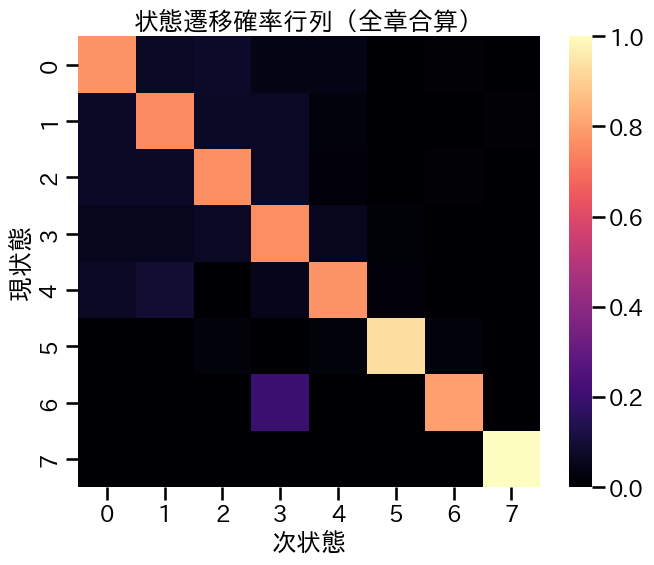

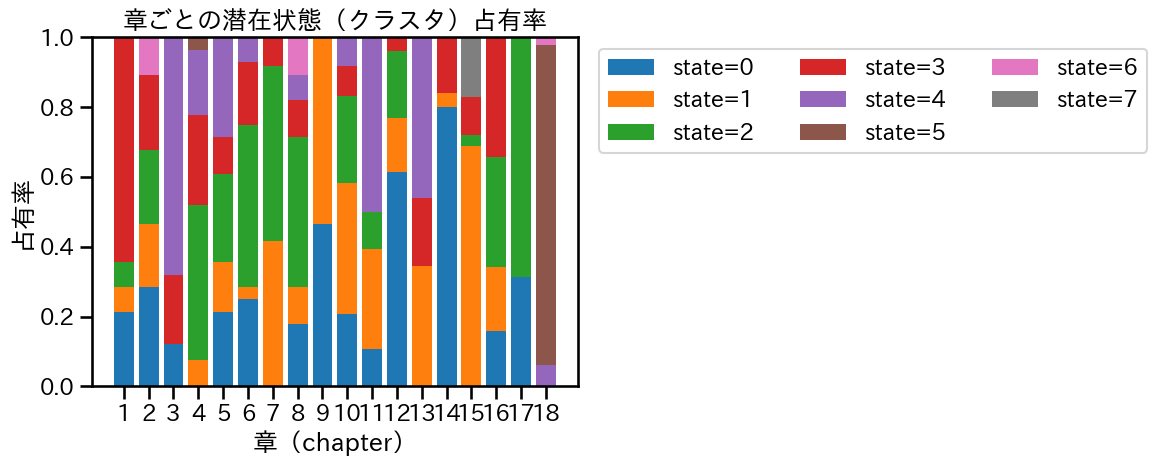

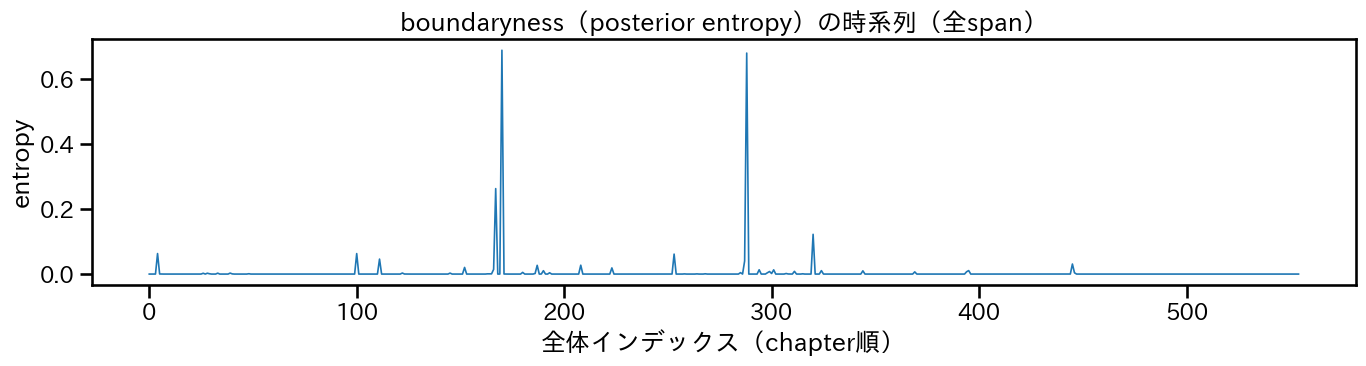

saved: fig_transition_matrix.png / fig_chapter_cluster_share.png / fig_entropy_timeseries.png


In [12]:
# ---- 遷移行列 ----
K = best_k
trans = np.zeros((K, K), dtype=float)
for _, g in df.groupby("chapter"):
    s = g.sort_values("span_id")["state"].to_numpy()
    for a, b in zip(s[:-1], s[1:]):
        trans[a, b] += 1
trans_prob = trans / np.maximum(trans.sum(axis=1, keepdims=True), 1)

plt.figure(figsize=(7,6))
sns.heatmap(trans_prob, cmap="magma", vmin=0, vmax=1)
plt.title("状態遷移確率行列（全章合算）")
plt.xlabel("次状態"); plt.ylabel("現状態")
plt.tight_layout()
plt.savefig("fig_transition_matrix.png", dpi=200)
plt.show()

# ---- 章別占有率（積み上げ）----
dist = df.groupby(["chapter","state"]).size().unstack(fill_value=0).sort_index()
dist_rate = dist.div(dist.sum(axis=1), axis=0)

plt.figure(figsize=(12,5))
bottom = np.zeros(len(dist_rate))
x = np.arange(len(dist_rate.index))
for s in dist_rate.columns:
    plt.bar(x, dist_rate[s].values, bottom=bottom, label=f"state={s}")
    bottom += dist_rate[s].values
plt.xticks(x, dist_rate.index)
plt.title("章ごとの潜在状態（クラスタ）占有率")
plt.xlabel("章（chapter）"); plt.ylabel("占有率")
plt.legend(ncol=3, bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.savefig("fig_chapter_cluster_share.png", dpi=200)
plt.show()

# ---- boundaryness（entropy）時系列 ----
plt.figure(figsize=(14,4))
plt.plot(df["entropy"].to_numpy(), lw=1.2)
plt.title("boundaryness（posterior entropy）の時系列（全span）")
plt.xlabel("全体インデックス（chapter順）"); plt.ylabel("entropy")
plt.tight_layout()
plt.savefig("fig_entropy_timeseries.png", dpi=200)
plt.show()

print("saved: fig_transition_matrix.png / fig_chapter_cluster_share.png / fig_entropy_timeseries.png")


,n,r,CI95%,p-val
pearson,555,0.022155,"[-0.06, 0.11]",0.602814


,n,r,CI95%,p-val
pearson,555,0.000184,"[-0.08, 0.08]",0.996558


,n,r,CI95%,p-val
pearson,555,0.042056,"[-0.04, 0.12]",0.32311


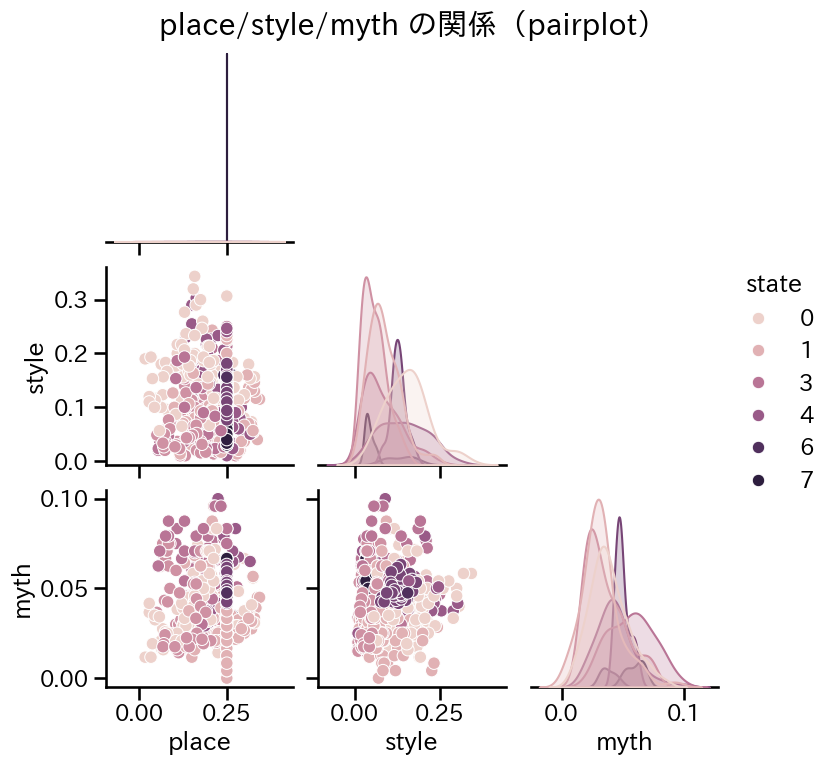

saved: fig_pairplot_layers.png / partial_corr_table.csv


In [13]:
def mean_prefix(prefix):
    cols = [c for c in df.columns if c.startswith(prefix)]
    return df[cols].mean(axis=1) if cols else None

df_corr = pd.DataFrame({
    "place": mean_prefix("place_"),
    "style": mean_prefix("style_"),
    "myth":  mean_prefix("myth_"),
    "chapter": df["chapter"].astype(int),
    "state": df["state"].astype(int),
}).dropna()

import pingouin as pg

pc1 = pg.partial_corr(df_corr, x="place", y="style", covar=["chapter"])
pc2 = pg.partial_corr(df_corr, x="place", y="myth",  covar=["chapter"])
pc3 = pg.partial_corr(df_corr, x="style", y="myth",  covar=["chapter"])

display(pc1); display(pc2); display(pc3)

sns.pairplot(df_corr[["place","style","myth","state"]], hue="state", corner=True)
plt.suptitle("place/style/myth の関係（pairplot）", y=1.02)
plt.savefig("fig_pairplot_layers.png", dpi=200)
plt.show()

pc_all = pd.concat([
    pc1.assign(pair="place-style"),
    pc2.assign(pair="place-myth"),
    pc3.assign(pair="style-myth"),
], ignore_index=True)
pc_all.to_csv("partial_corr_table.csv", index=False, encoding="utf-8-sig")
print("saved: fig_pairplot_layers.png / partial_corr_table.csv")


✅ 'state', 'entropy', 'margin' 列を作成しました。
   chapter  span_id  state       entropy
0        1        1      5  4.567638e-05
1        1        2      7 -1.000000e-09
2        1        3      7 -9.999995e-10
3        1        4      7  2.346436e-11
4        1        5      6  3.095945e-04
※ PCA/t-SNEの座標変数(coor)が見つからないため散布図はスキップします。


<Figure size 1000x600 with 0 Axes>

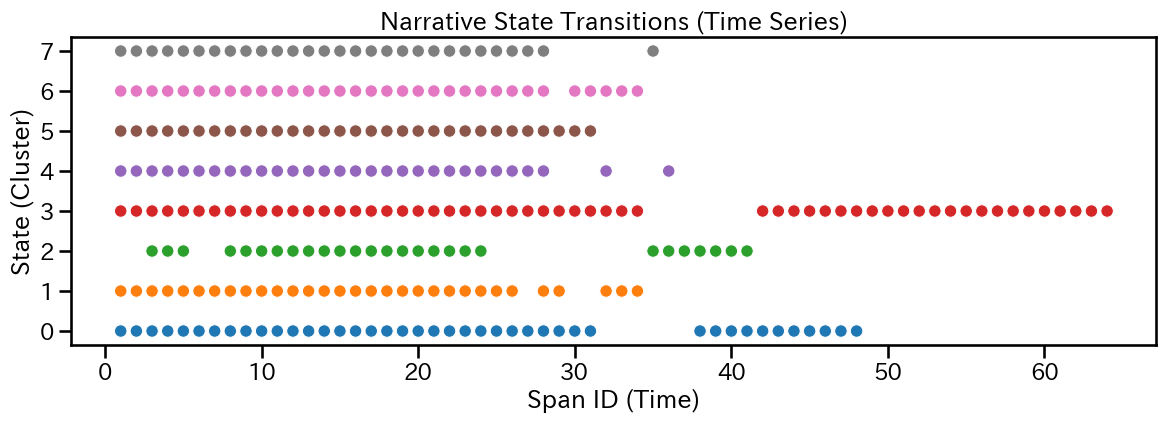

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# --- 1. GMMの学習と列の作成 (ここが抜けていました) ---
# レポートに基づき K=8 で学習
BEST_K = 8
gmm = GaussianMixture(n_components=BEST_K, covariance_type='full', random_state=42)
gmm.fit(Xz)  # Xzは正規化済みの特徴量データ

# データフレームに結果を格納
df['state'] = gmm.predict(Xz)
state_probs = gmm.predict_proba(Xz)

# 転調点分析用の指標計算（レポートの定義通り）
# entropy: 確率分布の散らばり（迷い）
df['entropy'] = -np.sum(state_probs * np.log(state_probs + 1e-9), axis=1)

# margin: 1位と2位の確率差（競合度）
sorted_probs = np.sort(state_probs, axis=1)
df['margin'] = sorted_probs[:, -1] - sorted_probs[:, -2]

print("✅ 'state', 'entropy', 'margin' 列を作成しました。")
print(df[['chapter', 'span_id', 'state', 'entropy']].head())


# --- 2. 可視化 (エラーが出ていた部分の修正版) ---
# state列が存在する状態で実行されます

# (A) 散布図のプロット (hue='state' を使用)
plt.figure(figsize=(10, 6))
# Xzを2次元圧縮している場合（例: PCAやt-SNEの coordinateがある場合）
# もし `coor` 変数がない場合はスキップされます
try:
    if 'coor' in locals():
        sns.scatterplot(x=coor[:, 0], y=coor[:, 1], hue=df['state'], palette='tab10', s=60, alpha=0.8)
        plt.title(f"GMM Clustering (K={BEST_K})")
        plt.show()
    else:
        print("※ PCA/t-SNEの座標変数(coor)が見つからないため散布図はスキップします。")
except Exception as e:
    print(f"散布図の描画スキップ: {e}")

# (B) 時系列プロット (章ごとの推移)
plt.figure(figsize=(14, 4))
sns.scatterplot(data=df, x='span_id', y='state', hue='state', palette='tab10', legend=False)
plt.title("Narrative State Transitions (Time Series)")
plt.xlabel("Span ID (Time)")
plt.ylabel("State (Cluster)")
plt.yticks(range(BEST_K))
plt.show()

## Appendix: External-criterion checks (from current notebook)

✅ GMM学習完了 (K=8)
✅ 列追加完了: 'state', 'entropy', 'margin'


,chapter,span_id,state,entropy
0,1,1,5,4.567638e-05
1,1,2,7,-1.000000e-09
2,1,3,7,-9.999995e-10
3,1,4,7,2.346436e-11
4,1,5,6,3.095945e-04


※ 変数 'coor' (次元圧縮後の座標) がないため、散布図はスキップします。


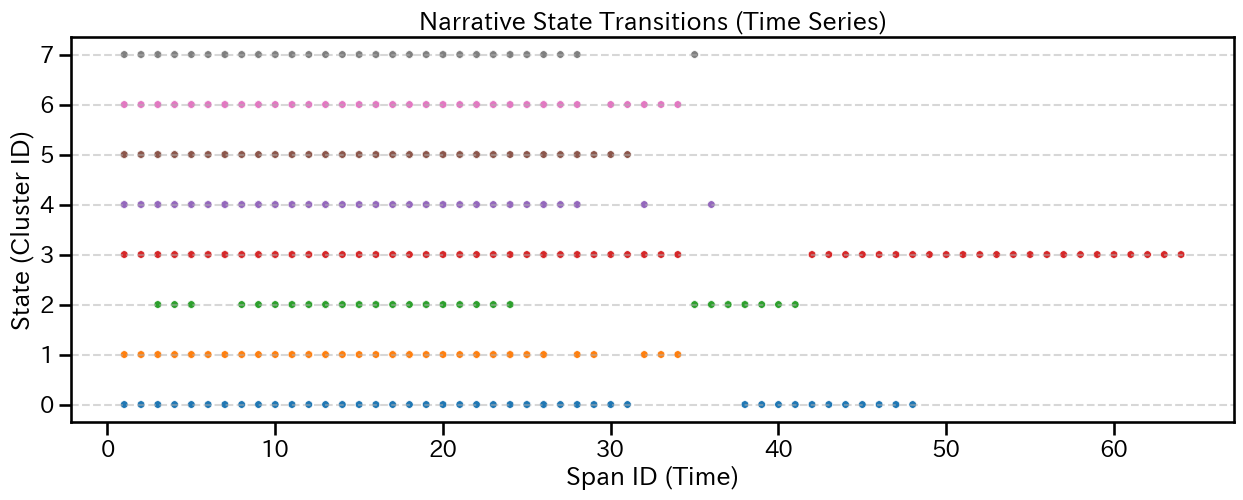

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# ---------------------------------------------------------
# 1. 「GMM学習」と「指標計算」の復元
# ---------------------------------------------------------

# もし前のセルで Xz (正規化済み特徴量) が作られていれば、それを使います。
# まだ定義されていない場合のエラーを防ぐためチェックします。
if 'Xz' not in locals():
    raise ValueError("エラー: 変数 'Xz' が見つかりません。このセルの前にある「データの読み込み・正規化」のセルを先に実行してください。")

# レポートに基づき K=8 で学習
BEST_K = 8
gmm = GaussianMixture(n_components=BEST_K, covariance_type='full', random_state=42)
gmm.fit(Xz)

# 予測結果をデータフレームに追加 (ここで 'state' 列が作られます)
df['state'] = gmm.predict(Xz)
state_probs = gmm.predict_proba(Xz)

# --- レポートに必要な指標の計算 ---
# (1) Entropy: 状態判定の「迷い」（値が大きいほど境界に近い）
df['entropy'] = -np.sum(state_probs * np.log(state_probs + 1e-9), axis=1)

# (2) Margin: 1位と2位の確率差（値が小さいほど競合している）
sorted_probs = np.sort(state_probs, axis=1)
df['margin'] = sorted_probs[:, -1] - sorted_probs[:, -2]

print(f"✅ GMM学習完了 (K={BEST_K})")
print("✅ 列追加完了: 'state', 'entropy', 'margin'")
display(df[['chapter', 'span_id', 'state', 'entropy']].head())


# ---------------------------------------------------------
# 2. 可視化（エラーが出ていた箇所の修正版）
# ---------------------------------------------------------

# (A) 散布図 (PCAなどの座標変数 coor がある場合のみ描画)
if 'coor' in locals():
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=coor[:, 0], y=coor[:, 1], hue=df['state'], palette='tab10', s=60, alpha=0.8)
    plt.title(f"GMM Clustering (K={BEST_K}) - Latent Space")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='State')
    plt.tight_layout()
    plt.show()
else:
    print("※ 変数 'coor' (次元圧縮後の座標) がないため、散布図はスキップします。")

# (B) 時系列プロット (章ごとの状態推移)
plt.figure(figsize=(15, 5))
# hue='state' を指定することで色分け
sns.scatterplot(data=df, x='span_id', y='state', hue='state', palette='tab10', legend=False, s=30)
plt.title("Narrative State Transitions (Time Series)")
plt.xlabel("Span ID (Time)")
plt.ylabel("State (Cluster ID)")
plt.yticks(range(BEST_K))  # Y軸を整数ステートのみに
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [16]:
# ============================================================
# Compatibility shim for "external-criterion checks" section
# - Build df from boundary_report.csv so the later cells can run
# ============================================================

import pandas as pd
import numpy as np
from pathlib import Path

# Prefer in-memory boundary report if exists; otherwise load from disk.
if "boundary_report_df" in globals():
    df = boundary_report_df.copy()
else:
    # Try common locations
    candidates = [
        Path("boundary_report.csv"),
        Path("outputs/boundary_report.csv"),
        Path("/content/outputs/boundary_report.csv"),
    ]
    found = next((p for p in candidates if p.exists()), None)
    if found is None:
        raise FileNotFoundError("boundary_report.csv not found. Run the pipeline above first.")
    df = pd.read_csv(found)

# Required columns for the external checks
if "scene_id" not in df.columns:
    if "chapter" in df.columns:
        df["scene_id"] = df["chapter"]
    else:
        df["scene_id"] = 0

if "global_step" not in df.columns and "t" not in df.columns:
    # Use rank if present, else row index
    if "rank" in df.columns:
        df["global_step"] = df["rank"]
    else:
        df["global_step"] = np.arange(len(df))

# Ensure numeric
for col in ["entropy","margin","scene_id","global_step"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

print("df ready for external checks:", df.shape, "cols=", [c for c in ["entropy","margin","scene_id","global_step"] if c in df.columns])
df.head(2)


df ready for external checks: (555, 14) cols= ['entropy', 'margin', 'scene_id', 'global_step']


,rank,chapter,span_id,transition_type,entropy,gmm_state_1based,top1_state_1based,top1_p,top2_state_1based,top2_p,margin,evidence_best,scene_id,global_step
0,0,1,1,intrusion,1.934171e-10,3,3,1.0,4,9.335736e-19,1.0,視覚描写（人物の出現）による開始。,1,0
1,1,1,2,script_switch,1.934171e-10,1,1,1.0,4,3.386588e-17,1.0,非英語（ラテン語）での引用/唱和。,1,1


In [17]:
# ============================================================
# Ulysses: External-criterion checks for high-entropy points
#  - Overall 2x2 test (margin-based ambiguity proxy)  ※KeyError対策版
#  - Transition type enrichment (Fisher 2x2 per type)
#  - place_/myth_ feature enrichment (mean diff + permutation p)
#  - Chapter concentration (density)
#  - Example extraction with evidence for high-interest findings
# ============================================================

import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from scipy.stats import fisher_exact

try:
    from IPython.display import display
except Exception:
    def display(x): print(x)

# ---------------------------
# Paths / Params
# ---------------------------
CSV_PATH = "/content/Mokafe-ulysses-narrative-gmm/data/sample/ulysses_stream.csv"

K = 8
SEED = 0

TOPN = 30          # entropy上位N
RANDN = 30         # random N
DROP_DUP_BY = None # 例: "global_step" があるなら "global_step" 推奨（重複排除）
N_PERM = 3000      # 置換検定回数（重いなら 1000 に下げてOK）

OUT_PREFIX = "extcrit"

# ---------------------------
# helper: evidence取得（ja優先）
# ---------------------------
def pick_evidence(row: pd.Series) -> str:
    for col in ["evidence_ja", "evidence_en", "evidence", "quote", "text", "raw_text"]:
        if col in row.index:
            v = row[col]
            if isinstance(v, str) and v.strip():
                return v.strip()
    return ""

# ---------------------------
# helper: permutation test for mean difference
# ---------------------------
def perm_pvalue_mean_diff(x_top, x_rnd, n_perm=3000, seed=0):
    x_top = np.asarray(x_top, dtype=float)
    x_rnd = np.asarray(x_rnd, dtype=float)
    x_all = np.concatenate([x_top, x_rnd])
    n_top = len(x_top)

    rng = np.random.default_rng(seed)
    obs = x_top.mean() - x_rnd.mean()

    cnt = 0
    for _ in range(int(n_perm)):
        rng.shuffle(x_all)
        d = x_all[:n_top].mean() - x_all[n_top:].mean()
        if abs(d) >= abs(obs):
            cnt += 1
    p = (cnt + 1) / (n_perm + 1)
    return float(obs), float(p)

# ---------------------------
# 1) Load + feature selection
# ---------------------------
df = pd.read_csv(CSV_PATH)

feature_cols = [
    c for c in df.columns
    if c.startswith("mode_")
    or c.startswith("cause_")
    or c.startswith("place_")
    or c.startswith("myth_")
    or c.startswith("style_")
]
if len(feature_cols) == 0:
    raise ValueError("No feature columns found. expected prefixes: mode_/cause_/place_/myth_/style_")

X = df[feature_cols].to_numpy()
Xz = StandardScaler().fit_transform(X)

# ---------------------------
# 2) Fit GMM + compute entropy/margin
# ---------------------------
gmm = GaussianMixture(
    n_components=K,
    covariance_type="diag",
    random_state=SEED,
    reg_covar=1e-6,
    max_iter=500,
    n_init=10
)
gmm.fit(Xz)
resp = gmm.predict_proba(Xz)

entropy = -(resp * np.log(resp + 1e-12)).sum(axis=1)

order = np.argsort(-resp, axis=1)
s1 = order[:, 0]
s2 = order[:, 1]
p1 = resp[np.arange(len(df)), s1]
p2 = resp[np.arange(len(df)), s2]
margin = p1 - p2

state_1based = resp.argmax(axis=1) + 1

dfm = df.copy()
dfm["entropy"] = entropy
dfm["margin"] = margin
dfm["gmm_state_1based"] = state_1based
dfm["top1_state_1based"] = s1 + 1
dfm["top2_state_1based"] = s2 + 1
dfm["top1_p"] = p1
dfm["top2_p"] = p2
dfm["evidence_best"] = dfm.apply(pick_evidence, axis=1)

# ---------------------------
# optional: drop duplicates by a key (e.g., global_step)
# ---------------------------
if DROP_DUP_BY is not None and DROP_DUP_BY in dfm.columns:
    dfm = dfm.drop_duplicates(subset=[DROP_DUP_BY], keep="first").reset_index(drop=True)

# ---------------------------
# 3) Select Top entropy vs Random
# ---------------------------
df_sorted = dfm.sort_values("entropy", ascending=False).reset_index(drop=True)

top = df_sorted.head(TOPN).copy()

remain = df_sorted.iloc[TOPN:].copy()
if len(remain) < RANDN:
    raise ValueError(f"Not enough remaining rows for Random{RANDN}. Remaining={len(remain)}")

rnd = remain.sample(n=RANDN, random_state=SEED).copy()

top["group"] = "Top"
rnd["group"] = "Random"

both = pd.concat([top, rnd], axis=0, ignore_index=True)

# ---------------------------
# 4) Overall 2x2: ambiguity proxy (margin-based)
#    ★KeyError対策：crosstab/locを使わず “直カウント” する
# ---------------------------

# groupを正規化（空白・大文字小文字・NaN対策）
both["group_norm"] = (
    both["group"]
    .astype(str)
    .str.strip()
    .str.lower()
)

# まず“本当に Random がいるか”をデバッグ表示
print("=== [debug] group_norm value_counts ===")
print(both["group_norm"].value_counts(dropna=False))

# Random基準のしきい値（rndが空ならここで落とす）
if len(rnd) == 0:
    raise ValueError("rnd is empty. check RANDN and dataset size.")
thr_margin = float(rnd["margin"].median())

both["ambiguous_by_margin"] = both["margin"] <= thr_margin

# マスク（Randomが存在しないなら「Top以外をRandom扱い」にフォールバック）
is_top = both["group_norm"].eq("top")
is_rnd = both["group_norm"].eq("random")

if is_rnd.sum() == 0:
    # ここが今回のエラーの“根本対策”
    print("[warn] No 'random' rows found in group_norm. Fallback: treat non-Top as Random.")
    is_rnd = ~is_top

a = int((is_top &  both["ambiguous_by_margin"]).sum())
b = int((is_top & ~both["ambiguous_by_margin"]).sum())
c = int((is_rnd &  both["ambiguous_by_margin"]).sum())
d = int((is_rnd & ~both["ambiguous_by_margin"]).sum())

odds, p_f = fisher_exact([[a, b], [c, d]], alternative="two-sided")

print("\n=== Overall 2×2 (ambiguous_by_margin; thr=median(Random margin)) ===")
print("flag=1(ambiguous) flag=0(not)")
print("Top   \t", a, b)
print("Random\t", c, d)
print(f"\nTop ambiguous率: {a/(a+b+1e-12):.3f} ({a}/{a+b})")
print(f"Rnd ambiguous率: {c/(c+d+1e-12):.3f} ({c}/{c+d})")
print(f"Fisher two-sided p = {p_f:.6g} | odds ratio = {odds}")
print(f"[debug] thr_margin = {thr_margin:.6f}")

pd.DataFrame({
    "group": ["Top", "Random"],
    "ambiguous_true": [a, c],
    "ambiguous_false": [b, d],
    "ambiguous_rate": [a/(a+b+1e-12), c/(c+d+1e-12)],
    "thr_margin": [thr_margin, thr_margin],
}).to_csv(f"{OUT_PREFIX}_overall_2x2.csv", index=False, encoding="utf-8-sig")

# ---------------------------
# 5) Transition type enrichment (Fisher 2x2 per type)
# ---------------------------
tt = None
if "transition_type" in dfm.columns:
    types = sorted(dfm["transition_type"].dropna().astype(str).unique().tolist())
    rows_tt = []
    for t in types:
        top_has = int((top["transition_type"].astype(str) == t).sum())
        top_no  = int(len(top) - top_has)
        rnd_has = int((rnd["transition_type"].astype(str) == t).sum())
        rnd_no  = int(len(rnd) - rnd_has)

        odds_t, p_t = fisher_exact([[top_has, top_no], [rnd_has, rnd_no]], alternative="two-sided")
        rows_tt.append({
            "transition_type": t,
            "top_count": top_has,
            "rnd_count": rnd_has,
            "top_rate": top_has / len(top),
            "rnd_rate": rnd_has / len(rnd),
            "diff_rate_top_minus_rnd": (top_has / len(top)) - (rnd_has / len(rnd)),
            "odds_ratio": float(odds_t) if np.isfinite(odds_t) else np.inf,
            "p_fisher_two_sided": float(p_t),
        })

    tt = pd.DataFrame(rows_tt).sort_values(
        ["p_fisher_two_sided", "diff_rate_top_minus_rnd"],
        ascending=[True, False]
    )
    print("\n=== Transition-type enrichment (exploratory) ===")
    display(tt.head(20))
    tt.to_csv(f"{OUT_PREFIX}_transition_type_fisher.csv", index=False, encoding="utf-8-sig")
else:
    print("\n[skip] 'transition_type' column not found. transition enrichment skipped.")

# ---------------------------
# 6) place_/myth_ feature enrichment: mean diff + permutation p
# ---------------------------
place_cols = [c for c in feature_cols if c.startswith("place_")]
myth_cols  = [c for c in feature_cols if c.startswith("myth_")]

def feature_enrichment(cols, label):
    if len(cols) == 0:
        print(f"\n[skip] no {label} columns found.")
        return None

    rows = []
    for col in cols:
        x_top = top[col].fillna(0).to_numpy()
        x_rnd = rnd[col].fillna(0).to_numpy()
        diff, p_perm = perm_pvalue_mean_diff(x_top, x_rnd, n_perm=N_PERM, seed=SEED)
        rows.append({
            "feature": col,
            "mean_top": float(np.mean(x_top)),
            "mean_rnd": float(np.mean(x_rnd)),
            "diff_mean_top_minus_rnd": diff,
            "p_perm_two_sided": p_perm,
        })

    out = pd.DataFrame(rows).sort_values(
        ["p_perm_two_sided", "diff_mean_top_minus_rnd"],
        ascending=[True, False]
    )
    print(f"\n=== {label} enrichment (mean diff + permutation) ===")
    display(out.head(20))
    out.to_csv(f"{OUT_PREFIX}_{label}_enrichment_perm.csv", index=False, encoding="utf-8-sig")
    return out

place_enr = feature_enrichment(place_cols, "place")
myth_enr  = feature_enrichment(myth_cols, "myth")

# ---------------------------
# 7) Chapter concentration (density)
# ---------------------------
ch = None
if "chapter" in dfm.columns:
    total_by_ch = dfm.groupby("chapter").size().rename("total_n")
    top_by_ch = top.groupby("chapter").size().rename("top_n")
    rnd_by_ch = rnd.groupby("chapter").size().rename("rnd_n")

    ch = pd.concat([total_by_ch, top_by_ch, rnd_by_ch], axis=1).fillna(0).reset_index()
    ch["top_density"] = ch["top_n"] / ch["total_n"].replace(0, np.nan)
    ch["rnd_density"] = ch["rnd_n"] / ch["total_n"].replace(0, np.nan)
    ch = ch.sort_values("top_density", ascending=False)

    print("\n=== Chapter concentration (Top density vs Random density) ===")
    display(ch.head(30))
    ch.to_csv(f"{OUT_PREFIX}_chapter_density.csv", index=False, encoding="utf-8-sig")
else:
    print("\n[skip] 'chapter' column not found. chapter density skipped.")

# ---------------------------
# 8) Example extraction for high-interest findings
# ---------------------------
examples = []

if tt is not None and len(tt) > 0 and "transition_type" in top.columns:
    tt_hi = tt.sort_values("diff_rate_top_minus_rnd", ascending=False).head(3)["transition_type"].tolist()
    for t in tt_hi:
        ex = top[top["transition_type"].astype(str) == str(t)].copy()
        ex = ex.sort_values(["entropy", "margin"], ascending=[False, True]).head(5)
        if len(ex) > 0:
            ex["why_tag"] = f"transition_type={t}"
            examples.append(ex)

def pick_feature_examples(enr_df, tag_prefix, cols_pick=2):
    if enr_df is None or len(enr_df) == 0:
        return
    feats = enr_df.sort_values("diff_mean_top_minus_rnd", ascending=False).head(cols_pick)["feature"].tolist()
    for f in feats:
        ex = top.copy()
        ex = ex.sort_values([f, "entropy"], ascending=[False, False]).head(5)
        ex["why_tag"] = f"{tag_prefix}:{f}"
        examples.append(ex)

pick_feature_examples(place_enr, "place_feature", cols_pick=2)
pick_feature_examples(myth_enr,  "myth_feature",  cols_pick=2)

if len(examples) > 0:
    ex_all = pd.concat(examples, axis=0, ignore_index=True)

    show_cols_candidates = [
        "why_tag",
        "chapter", "span_id", "transition_type",
        "entropy", "margin",
        "gmm_state_1based",
        "top1_state_1based", "top1_p",
        "top2_state_1based", "top2_p",
        "evidence_best",
        "span_text_en", "span_text_ja",
    ]
    show_cols = [c for c in show_cols_candidates if c in ex_all.columns]
    ex_all = ex_all[show_cols].copy()

    print("\n=== Extracted examples for high-interest findings ===")
    display(ex_all)
    ex_all.to_csv(f"{OUT_PREFIX}_examples_high_interest.csv", index=False, encoding="utf-8-sig")
else:
    print("\n[info] No examples extracted (likely missing columns like transition_type).")

print("\n[Saved files]")
print(f" - {OUT_PREFIX}_overall_2x2.csv")
if tt is not None:        print(f" - {OUT_PREFIX}_transition_type_fisher.csv")
if place_enr is not None: print(f" - {OUT_PREFIX}_place_enrichment_perm.csv")
if myth_enr is not None:  print(f" - {OUT_PREFIX}_myth_enrichment_perm.csv")
if ch is not None:        print(f" - {OUT_PREFIX}_chapter_density.csv")
print(f" - {OUT_PREFIX}_examples_high_interest.csv (if created)")




=== [debug] group_norm value_counts ===
group_norm
top       30
random    30
Name: count, dtype: int64

=== Overall 2×2 (ambiguous_by_margin; thr=median(Random margin)) ===
flag=1(ambiguous) flag=0(not)
Top   	 30 0
Random	 15 15

Top ambiguous率: 1.000 (30/30)
Rnd ambiguous率: 0.500 (15/30)
Fisher two-sided p = 5.83213e-06 | odds ratio = inf
[debug] thr_margin = 1.000000

=== Transition-type enrichment (exploratory) ===


,transition_type,top_count,rnd_count,top_rate,rnd_rate,diff_rate_top_minus_rnd,odds_ratio,p_fisher_two_sided
6,script_switch,2,6,0.066667,0.200000,-0.133333,0.285714,0.254214
5,rumination,5,2,0.166667,0.066667,0.100000,2.800000,0.423810
1,contrast,4,2,0.133333,0.066667,0.066667,2.153846,0.670749
8,semantic_association,7,5,0.233333,0.166667,0.066667,1.521739,0.748050
2,goal_task,0,0,0.000000,0.000000,0.000000,inf,1.000000
3,intrusion,7,7,0.233333,0.233333,0.000000,1.000000,1.000000
4,phonetic_association,0,1,0.000000,0.033333,-0.033333,0.000000,1.000000
7,self_censor,0,1,0.000000,0.033333,-0.033333,0.000000,1.000000
0,completion,5,6,0.166667,0.200000,-0.033333,0.800000,1.000000



=== place enrichment (mean diff + permutation) ===


,feature,mean_top,mean_rnd,diff_mean_top_minus_rnd,p_perm_two_sided
2,place_2,0.145333,0.311000,-0.165667,0.030323
0,place_0,0.092667,0.043333,0.049333,0.114295
3,place_3,0.097000,0.151000,-0.054000,0.312896
1,place_1,0.381000,0.354667,0.026333,0.717094



=== myth enrichment (mean diff + permutation) ===


,feature,mean_top,mean_rnd,diff_mean_top_minus_rnd,p_perm_two_sided
0,myth_0,0.045000,0.040667,0.004333,0.502832
1,myth_1,0.028667,0.027667,0.001000,0.876708
3,myth_3,0.057667,0.059333,-0.001667,0.906365
2,myth_2,0.038667,0.039000,-0.000333,0.990670



=== Chapter concentration (Top density vs Random density) ===


,chapter,total_n,top_n,rnd_n,top_density,rnd_density
6,7,24,5.0,2.0,0.208333,0.083333
4,5,28,4.0,0.0,0.142857,0.000000
11,12,26,3.0,2.0,0.115385,0.076923
10,11,28,3.0,3.0,0.107143,0.107143
9,10,24,2.0,0.0,0.083333,0.000000
15,16,38,3.0,1.0,0.078947,0.026316
12,13,26,2.0,0.0,0.076923,0.000000
0,1,28,2.0,2.0,0.071429,0.071429
3,4,27,1.0,3.0,0.037037,0.111111
1,2,28,1.0,0.0,0.035714,0.000000



=== Extracted examples for high-interest findings ===


,why_tag,chapter,span_id,transition_type,entropy,margin,gmm_state_1based,top1_state_1based,top1_p,top2_state_1based,top2_p,evidence_best
0,transition_type=rumination,7,9,rumination,0.693457,0.004782,2,2,0.502376,4,0.497594,疑問文＋「Thumping」反復で作業音が思考に食い込む。
1,transition_type=rumination,5,19,rumination,0.349407,0.777224,5,5,0.888612,8,0.111388,「Poor papa!」の感嘆から過去行為（didn’t go）へ移る。
2,transition_type=rumination,1,25,rumination,0.031926,0.989831,7,7,0.994915,8,0.005085,自己位置づけ（servant/masters）で内的整理。
3,transition_type=rumination,9,9,rumination,0.021315,0.994570,8,8,0.997062,2,0.002492,短文断片の連鎖で内的独語が優勢。
4,transition_type=rumination,16,14,rumination,0.020361,0.994021,5,5,0.997011,8,0.002989,想起努力（recollect）が中心。
5,transition_type=semantic_association,11,13,semantic_association,0.685999,0.119423,4,4,0.559711,2,0.440289,視覚（eye）＋読字（read）。
6,transition_type=semantic_association,7,10,semantic_association,0.554764,0.746200,5,5,0.837654,2,0.091454,断片文が連なり、内言の流れが優位。
7,transition_type=semantic_association,11,25,semantic_association,0.536416,0.544708,4,4,0.772354,7,0.227646,By の反復で列挙リズムが支配。
8,transition_type=semantic_association,17,28,semantic_association,0.534026,0.548604,7,7,0.774302,2,0.225698,"聴覚入力（sound, chime）でアンカーが補強。"
9,transition_type=semantic_association,7,15,semantic_association,0.362360,0.764567,2,2,0.882283,4,0.117716,「Reads」「Quickly」「practice」で観察→推測が同一流れ。



[Saved files]
 - extcrit_overall_2x2.csv
 - extcrit_transition_type_fisher.csv
 - extcrit_place_enrichment_perm.csv
 - extcrit_myth_enrichment_perm.csv
 - extcrit_chapter_density.csv
 - extcrit_examples_high_interest.csv (if created)


確認: 'gmm_state_1based' 列を使用して描画します。

--- Chapter 7 詳細データ ---
Span 9: State=2, Type=rumination, Entropy=0.6935


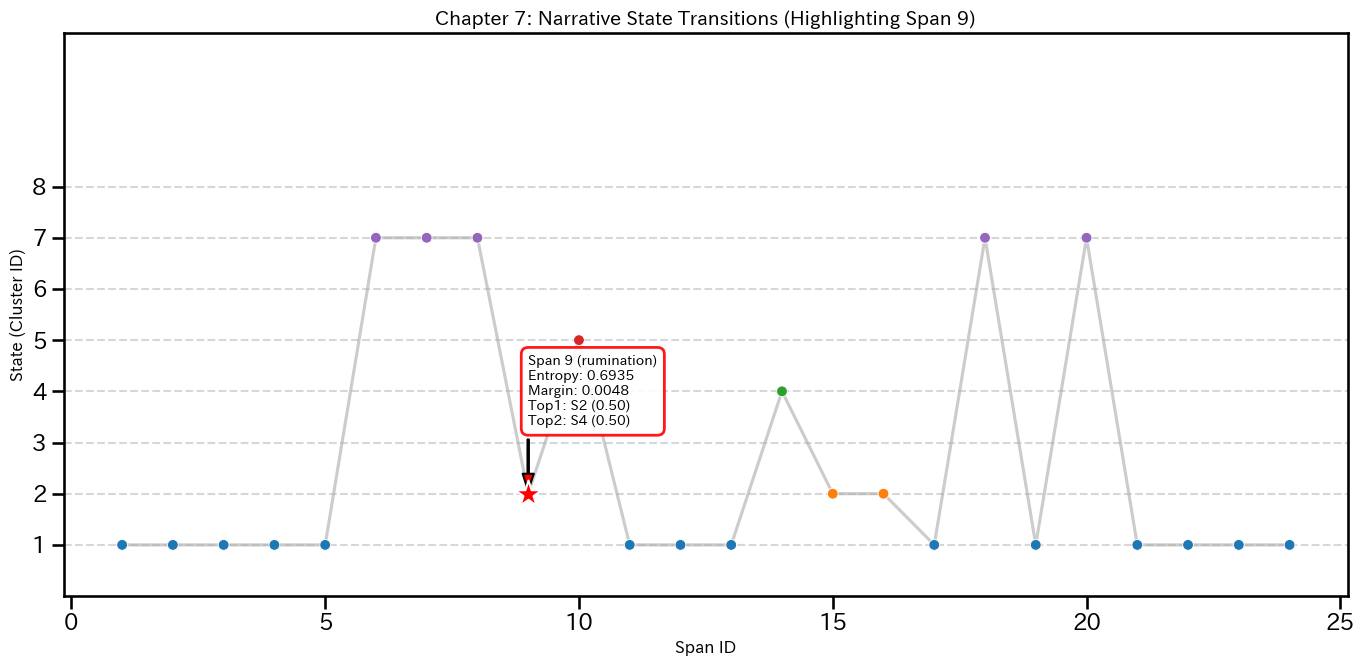

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# --- 1. データフレームと列の復旧（安全策） ---
# dfm（分析済み）があれば優先、なければ df を使用
target_df = dfm.copy() if 'dfm' in locals() else df.copy()

# 列の存在チェック
has_gmm = 'gmm_state_1based' in target_df.columns
has_state = 'state' in target_df.columns

# どちらもなければ、GMMを使って再作成する
if not has_gmm and not has_state:
    print("Warning: State列が見つからないため、GMMモデルから再生成します...")
    feature_cols = [c for c in target_df.columns if c.startswith(('mode_', 'cause_', 'place_', 'myth_', 'style_'))]

    if len(feature_cols) == 0:
        raise ValueError("エラー: 特徴量列（mode_など）が見つかりません。データの読み込みセルを実行し直してください。")

    # GMM予測の実行
    X_tmp = target_df[feature_cols].fillna(0).to_numpy()
    Xz_tmp = StandardScaler().fit_transform(X_tmp)

    # gmmモデルがメモリにあるか確認
    if 'gmm' in locals():
        target_df['state'] = gmm.predict(Xz_tmp) + 1 # 1-based
        st_col = 'state'
        print("-> 再生成完了: 'state' 列（1-based）を追加しました。")
    else:
        raise ValueError("エラー: GMMモデルが見つかりません。'Analysis Part'（Step 1）のコードをもう一度実行してください。")
else:
    # 存在する列名を使用
    st_col = 'gmm_state_1based' if has_gmm else 'state'
    print(f"確認: '{st_col}' 列を使用して描画します。")

# --- 2. ターゲット設定 (7章9番のみ) ---
CHAPTER = 7
SPANS = [9]  # 9番のみ指定

# グラフ準備
fig, ax = plt.subplots(figsize=(14, 7))

# (A) 時系列プロット
ch_data = target_df[target_df['chapter'] == CHAPTER].sort_values('span_id')

# 線と点を描画
sns.lineplot(data=ch_data, x='span_id', y=st_col, color='gray', alpha=0.4, zorder=1, ax=ax)
sns.scatterplot(data=ch_data, x='span_id', y=st_col, hue=st_col, palette='tab10', s=60, zorder=2, legend=False, ax=ax)

# --- 3. 詳細情報の注釈を追加 ---
# 9番のみなので赤色で強調
colors = ['red']
offsets = [2]     # テキストを少し上に表示

print(f"\n--- Chapter {CHAPTER} 詳細データ ---")

for i, span_id in enumerate(SPANS):
    row = target_df[(target_df['chapter'] == CHAPTER) & (target_df['span_id'] == span_id)]

    if len(row) > 0:
        val_y = row[st_col].values[0]
        col_color = colors[i]

        # グラフ上のポイントを強調（星型）
        ax.scatter(span_id, val_y, c=col_color, s=400, marker='*', edgecolors='white', zorder=10)

        # データの取得
        ent = row['entropy'].values[0] if 'entropy' in row else 0
        mar = row['margin'].values[0] if 'margin' in row else 0
        t_type = row['transition_type'].values[0] if 'transition_type' in row else "N/A"

        # Top1 / Top2 情報の取得
        if 'top1_state_1based' in row:
            top1_s = row['top1_state_1based'].values[0]
            top1_p = row['top1_p'].values[0]
            top2_s = row['top2_state_1based'].values[0]
            top2_p = row['top2_p'].values[0]
        else:
            top1_s, top1_p, top2_s, top2_p = ("-", 0, "-", 0)

        # コンソール表示
        print(f"Span {span_id}: State={val_y}, Type={t_type}, Entropy={ent:.4f}")

        # 詳細テキストを作成
        info_text = (
            f"Span {span_id} ({t_type})\n"
            f"Entropy: {ent:.4f}\n"
            f"Margin: {mar:.4f}\n"
            f"Top1: S{top1_s} ({top1_p:.2f})\n"
            f"Top2: S{top2_s} ({top2_p:.2f})"
        )

        # テキストボックスを表示
        y_offset = offsets[i]
        text_y = val_y + y_offset

        ax.annotate(info_text,
                    xy=(span_id, val_y),
                    xytext=(span_id, text_y),
                    arrowprops=dict(facecolor=col_color, shrink=0.05, width=1, headwidth=8),
                    color='black', fontsize=10, ha='left', va='center',
                    bbox=dict(boxstyle="round,pad=0.5", fc="white", ec=col_color, alpha=0.9, linewidth=2))

# --- 4. グラフの装飾 ---
ax.set_title(f"Chapter {CHAPTER}: Narrative State Transitions (Highlighting Span {SPANS[0]})", fontsize=14)
ax.set_xlabel("Span ID", fontsize=12)
ax.set_ylabel("State (Cluster ID)", fontsize=12)
ax.grid(True, axis='y', linestyle='--', alpha=0.5)

# Y軸設定
max_state = target_df[st_col].max()
ax.set_yticks(range(1, int(max_state) + 1))
ax.set_ylim(0, int(max_state) + 3) # 上部のテキストスペース確保

plt.tight_layout()
plt.show()